In [1]:
!unzip mnist.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: mnist/train/5/2413.png  
  inflating: mnist/train/5/2445.png  
  inflating: mnist/train/5/2452.png  
  inflating: mnist/train/5/2460.png  
  inflating: mnist/train/5/2476.png  
  inflating: mnist/train/5/2487.png  
  inflating: mnist/train/5/2515.png  
  inflating: mnist/train/5/2518.png  
  inflating: mnist/train/5/2525.png  
  inflating: mnist/train/5/2526.png  
  inflating: mnist/train/5/2540.png  
  inflating: mnist/train/5/2545.png  
  inflating: mnist/train/5/2546.png  
  inflating: mnist/train/5/2554.png  
  inflating: mnist/train/5/2556.png  
  inflating: mnist/train/5/2558.png  
  inflating: mnist/train/5/2559.png  
  inflating: mnist/train/5/2569.png  
  inflating: mnist/train/5/2573.png  
  inflating: mnist/train/5/2574.png  
  inflating: mnist/train/5/2581.png  
  inflating: mnist/train/5/2586.png  
  inflating: mnist/train/5/2597.png  
  inflating: mnist/train/5/2604.png  
  inflating: mnist/tr

In [2]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/1/6783.png'

In [3]:
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [4]:
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [5]:

#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [6]:

#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

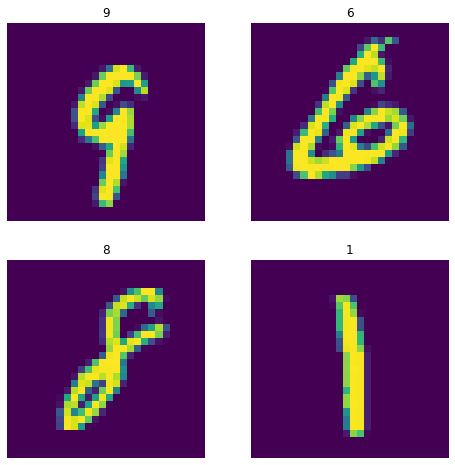

In [7]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [9]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

#Modelo 1

In [110]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 200

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [111]:
#--- Definimos una ANN simple sin utilizar batch_size

input_dim = 28*28
out_dim = 10
hidden = 50

learning_rate = 0.001
weight_decay = 0.00001

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.Tanh(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

In [112]:

from sklearn.metrics import f1_score

n_epoch = 30

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

total_it = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()

    Xtr = X_train_batch.view(X_train_batch.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_batch,Y_pred, average='macro') )
  
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    total_it += 1
  if((epoch+1)%10==0):
    print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch, loss_train[-1], f1_train[-1], acc_train[-1]) )

Epoch [10/30], loss: 0.41504883766174316. f1:0.8745241563239624 acc: 0.8700000047683716 
Epoch [20/30], loss: 0.3587838411331177. f1:0.8853272006734336 acc: 0.8899999856948853 
Epoch [30/30], loss: 0.297153115272522. f1:0.8903632517094199 acc: 0.8999999761581421 


#Modelo 2

In [116]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 350

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [117]:
#--- Definimos una ANN simple sin utilizar batch_size

input_dim = 28*28
out_dim = 10
hidden = 50

learning_rate = 0.01
weight_decay = 0.0001

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.Tanh(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

In [118]:

from sklearn.metrics import f1_score

n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

total_it = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()

    Xtr = X_train_batch.view(X_train_batch.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_batch,Y_pred, average='macro') )
  
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    total_it += 1
  if((epoch+1)%10==0):
    print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch, loss_train[-1], f1_train[-1], acc_train[-1]) )

Epoch [10/100], loss: 1.073378324508667. f1:0.6168498168498168 acc: 0.6200000047683716 
Epoch [20/100], loss: 0.8136136531829834. f1:0.7248809523809524 acc: 0.7400000095367432 
Epoch [30/100], loss: 0.6863127946853638. f1:0.657047952047952 acc: 0.7400000095367432 
Epoch [40/100], loss: 0.7135717272758484. f1:0.7204151404151404 acc: 0.7400000095367432 
Epoch [50/100], loss: 0.5921867489814758. f1:0.7986291486291487 acc: 0.7799999713897705 
Epoch [60/100], loss: 0.9509554505348206. f1:0.639102564102564 acc: 0.6399999856948853 
Epoch [70/100], loss: 0.5487270951271057. f1:0.7590586314270524 acc: 0.8399999737739563 
Epoch [80/100], loss: 0.6400065422058105. f1:0.7595139363560416 acc: 0.7799999713897705 
Epoch [90/100], loss: 0.5355627536773682. f1:0.7221123321123321 acc: 0.7599999904632568 
Epoch [100/100], loss: 0.8270561695098877. f1:0.8118542568542569 acc: 0.7599999904632568 


#Segundo
## a)
### Vemos que el modelo con 30 epocas, 0.001 learning rate, 0.00001 weight_decay, batch size 200 en comparacion con el modelo  de 100 epocas, 0.01 learning rate, 0.0001 weight_decay, batch size 350
## b) 
### Los mejores metaparametros mas importantes para obtener resultados optimos son: Batch size, debido a que si tenemos un menor tamaño en el estos subconjuntos se va a tener unos mejores resultados, otro parametro importante es learning rate que no se puede ni aumentar ni desminuir demasiado porque cambia mucho los resultados. El siguiente en el orden es weight_decay que es importante que sea mas bajo para obtener. Por ultimo, el parametro con menos importancia es el numero de epocas porque como se vio en el segundo modelo es posible que existan muchas fluctuaciones en los resultados a medida que pasan . Además, no es muy optimo subir el numero de epocas porque se demora un tiempo computacional muy alto. (Esta era una hipotesis que tenia pero en la tabla de confusion me logré dar cuenta de la diferencia dando como resultado el siguiente orden de mayor a menor importancia:  Learning rate, Numero de epocas, batch size y Weight deca )

In [120]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

In [121]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  CM(Y_valid, Y_pred, 10)

  0%|          | 0/16 [00:00<?, ?it/s]

ne: 30, hd:50, wd:1e-05, lr: 0.001, bs:200 
Valid Evaluation loss: 1.1606664657592773. f1:0.7412636310906943 acc: 0.7540000081062317 


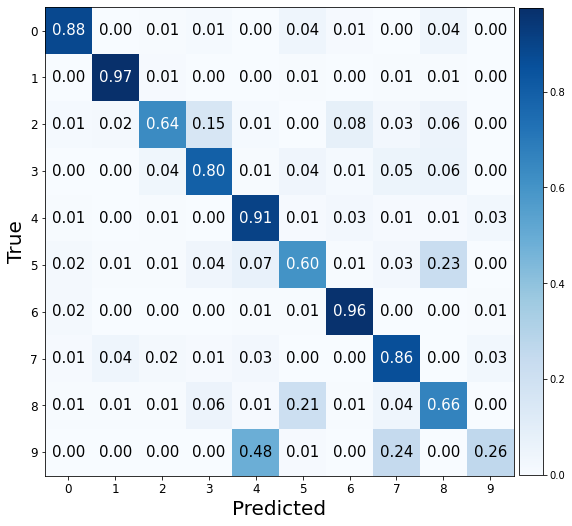

###################

ne: 30, hd:50, wd:0.0001, lr: 0.001, bs:200 
Valid Evaluation loss: 1.3281160593032837. f1:0.6891721658458229 acc: 0.7200000286102295 


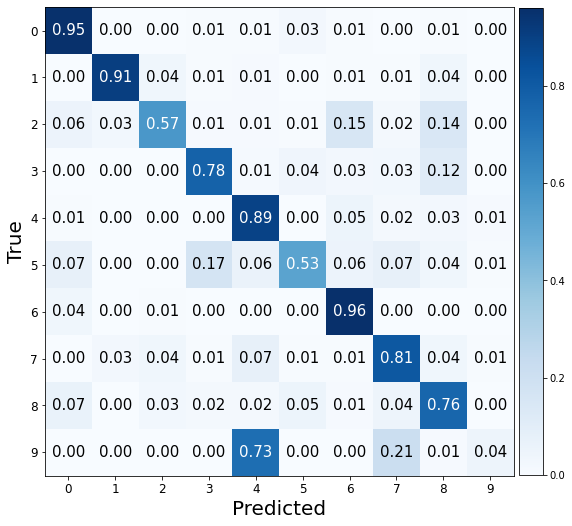

###################

ne: 30, hd:50, wd:1e-05, lr: 0.01, bs:200 
Valid Evaluation loss: 0.5582779049873352. f1:0.8324638802825819 acc: 0.8324999809265137 


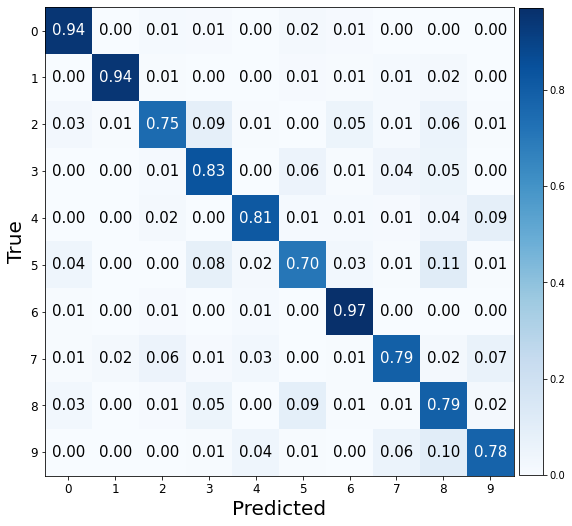

###################

ne: 30, hd:50, wd:0.0001, lr: 0.01, bs:200 
Valid Evaluation loss: 0.5358133316040039. f1:0.8342528299396399 acc: 0.8349999785423279 


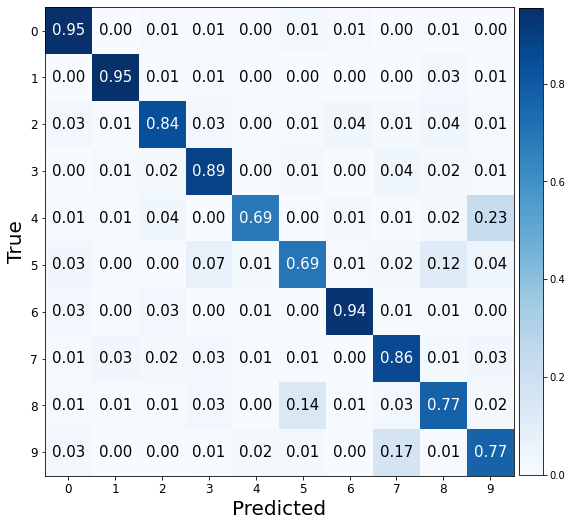

###################

ne: 30, hd:50, wd:1e-05, lr: 0.001, bs:350 
Valid Evaluation loss: 1.2895270586013794. f1:0.5695864448062997 acc: 0.6035000085830688 


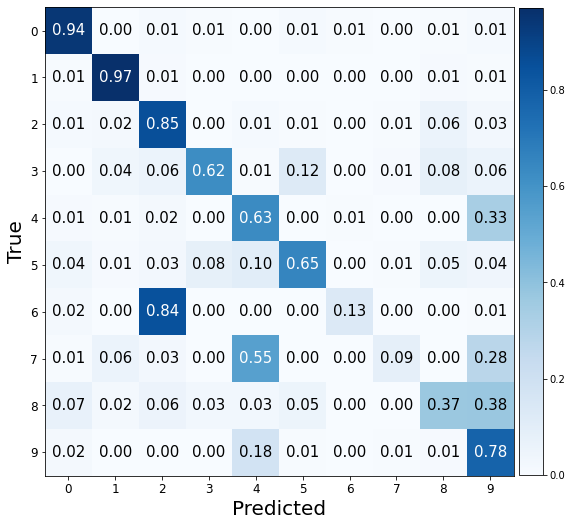

###################

ne: 30, hd:50, wd:0.0001, lr: 0.001, bs:350 
Valid Evaluation loss: 1.2753452062606812. f1:0.7222397194905013 acc: 0.7450000047683716 


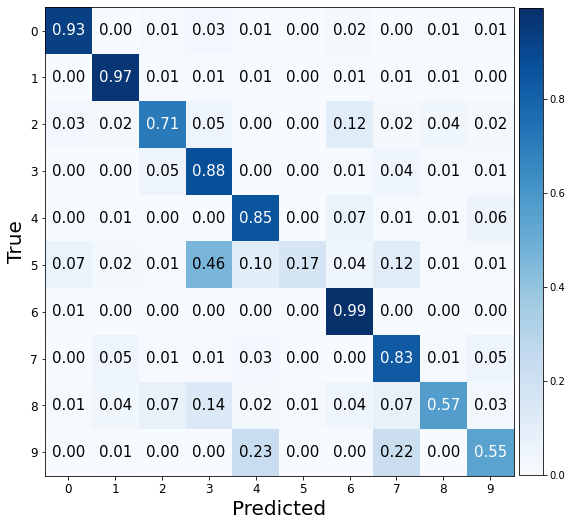

###################

ne: 30, hd:50, wd:1e-05, lr: 0.01, bs:350 
Valid Evaluation loss: 0.5964792966842651. f1:0.8168958936272365 acc: 0.8165000081062317 


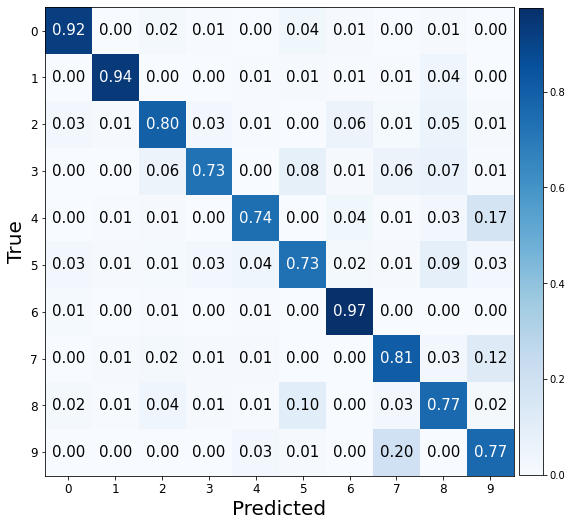

###################

ne: 30, hd:50, wd:0.0001, lr: 0.01, bs:350 
Valid Evaluation loss: 0.5392554402351379. f1:0.8412412146481106 acc: 0.8420000076293945 


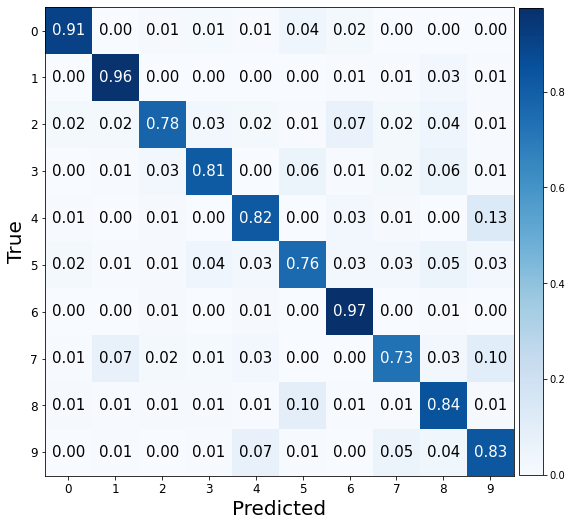

###################

ne: 100, hd:50, wd:1e-05, lr: 0.001, bs:200 
Valid Evaluation loss: 0.37850964069366455. f1:0.8904624904557762 acc: 0.890999972820282 


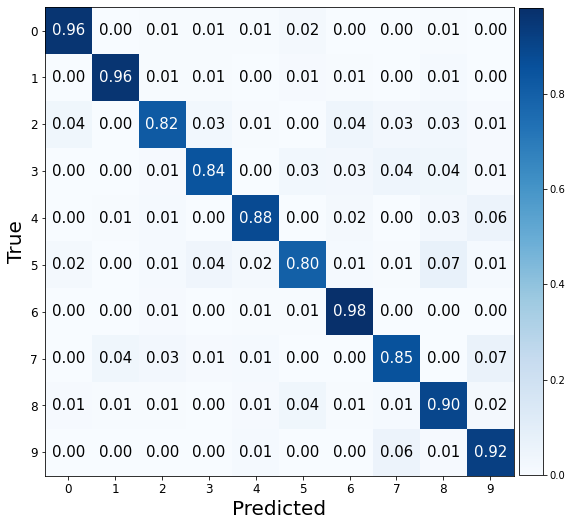

###################

ne: 100, hd:50, wd:0.0001, lr: 0.001, bs:200 
Valid Evaluation loss: 0.43984508514404297. f1:0.8638652538703904 acc: 0.8634999990463257 


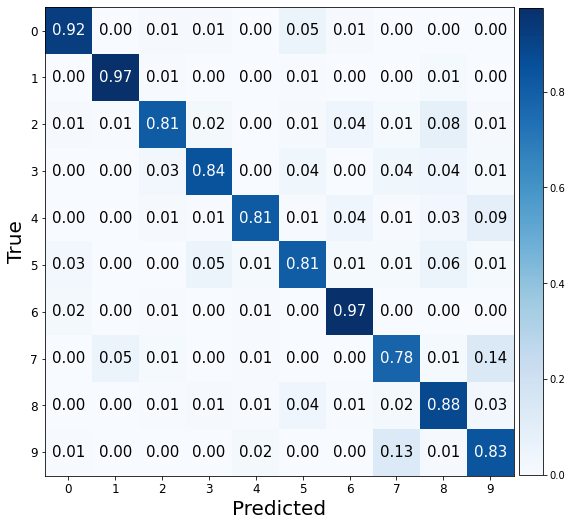

###################

ne: 100, hd:50, wd:1e-05, lr: 0.01, bs:200 
Valid Evaluation loss: 0.4122527539730072. f1:0.8714920274253458 acc: 0.871999979019165 


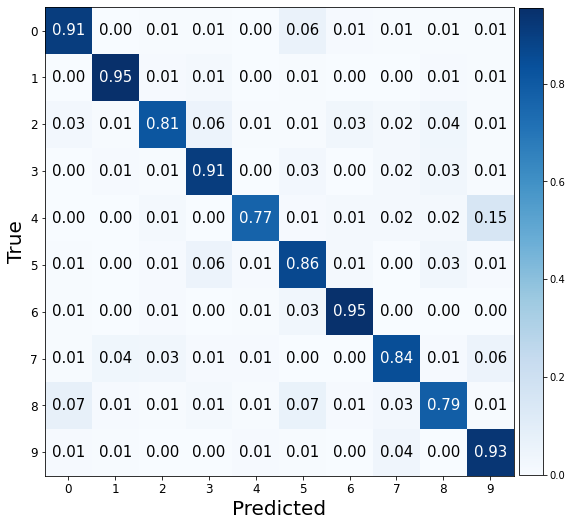

###################

ne: 100, hd:50, wd:0.0001, lr: 0.01, bs:200 
Valid Evaluation loss: 0.47388356924057007. f1:0.8568082307724927 acc: 0.8575000166893005 


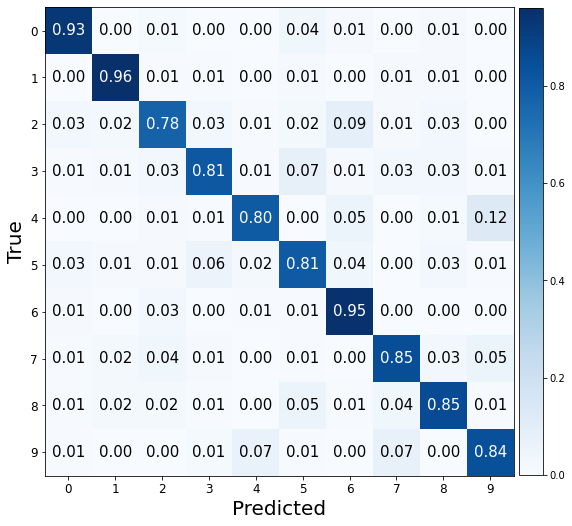

###################

ne: 100, hd:50, wd:1e-05, lr: 0.001, bs:350 
Valid Evaluation loss: 0.3783044219017029. f1:0.8835755343586993 acc: 0.8840000033378601 


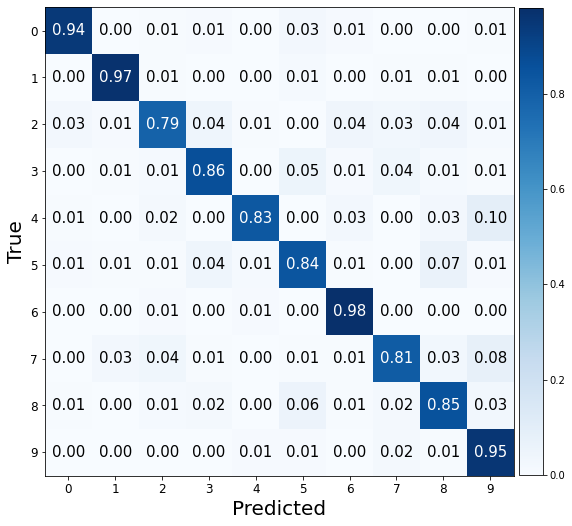

###################

ne: 100, hd:50, wd:0.0001, lr: 0.001, bs:350 
Valid Evaluation loss: 0.3884432911872864. f1:0.8816889635578431 acc: 0.8820000290870667 


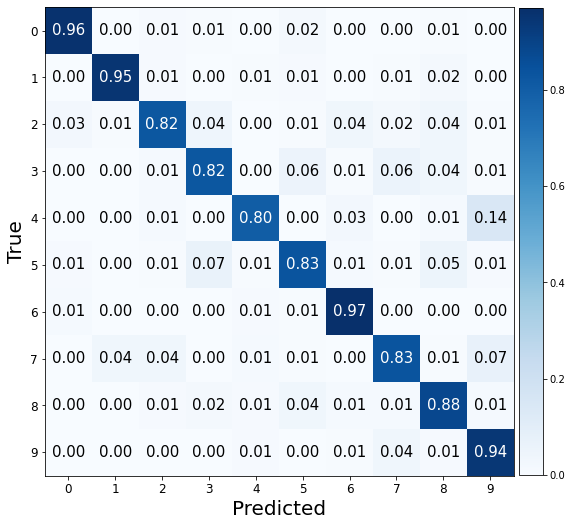

###################

ne: 100, hd:50, wd:1e-05, lr: 0.01, bs:350 
Valid Evaluation loss: 0.4345899522304535. f1:0.8636891916825201 acc: 0.8634999990463257 


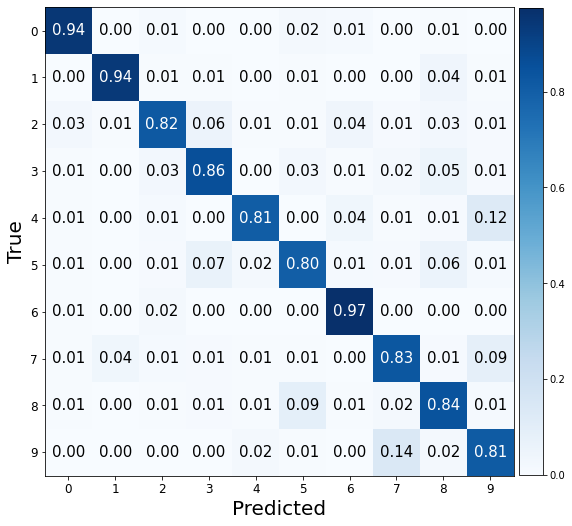

###################

ne: 100, hd:50, wd:0.0001, lr: 0.01, bs:350 
Valid Evaluation loss: 0.4618242681026459. f1:0.8604949993500665 acc: 0.8610000014305115 


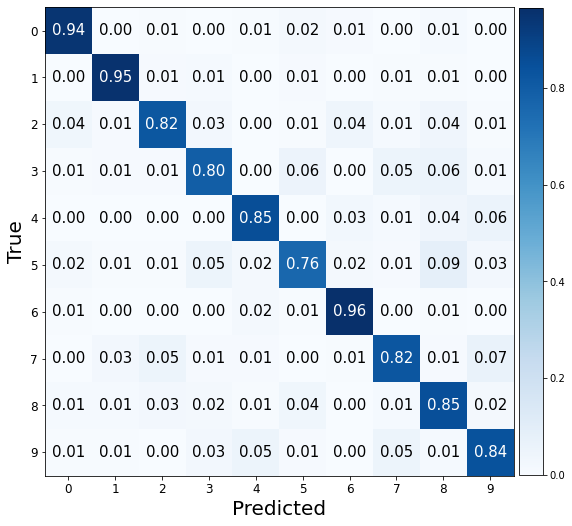

###################



In [127]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [200,350]
lr_list = [0.001,0.01]
wd_list = [0.00001,0.0001]
hd_list = 50
ne_list = [30,100]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        input_dim = 28*28
        out_dim = 10
        hd=50
        hidden = 50
        model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden),
          torch.nn.Tanh(), 
          torch.nn.Linear(hidden, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden, out_dim)
          )

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        criterion = torch.nn.CrossEntropyLoss()

        print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
        train_valid(model,ne,optimizer,criterion)
        print('###################\n')

        pbar.update()
pbar.close()

## Mini reporte
### Con la ayuda de nuestra tabla de confusion nos podemos dar cuenta la importancia de los metadatos como weight and learning rate. Con estas tablas y mirando cada una de las configuraciones posible podemos observar cosas importantes como: El modelo con  numero de epcas de 100, weight decay 1e-5, learning rate 0.001 y un batch size de 200 tiene una menor perdida y mayor score y accuracy (El modelo más optimo). En esta tabla de confusion se puede ver que en este modelo se obtienen la mayor cantidad de verdaderos positivos y verdadero negativos y  una menor cantidad de falsos postivos y falso negativos. Otra cosa muy importante que se puede observar es como cambian los resultados si mantenemos constantes los metaparametros y si variamos  uno. Por ejemplo, Si cambiamos Weight decay en la perdidad no se verá un cambio muy drastico. Mientras que learning rate cambia de una manera drastica si la disminuimos obteniendo mejores resultados. Para batch size, los resultados no cambian pero se ve una mejoria si se disminuye este numero. Por ultimo, el numero epocas cambia drasticamente nuestros scores pero a  un mayor tiempo computacional. En resumen, podemos organizar nuestros metaparametros de mayor a menor importancia como: Learning rate, Numero de epocas, batch size y Weight decay.